Path found in 130 iterations, Time: 0.13 seconds
Path Length: 293.45, Smoothness: 15.10


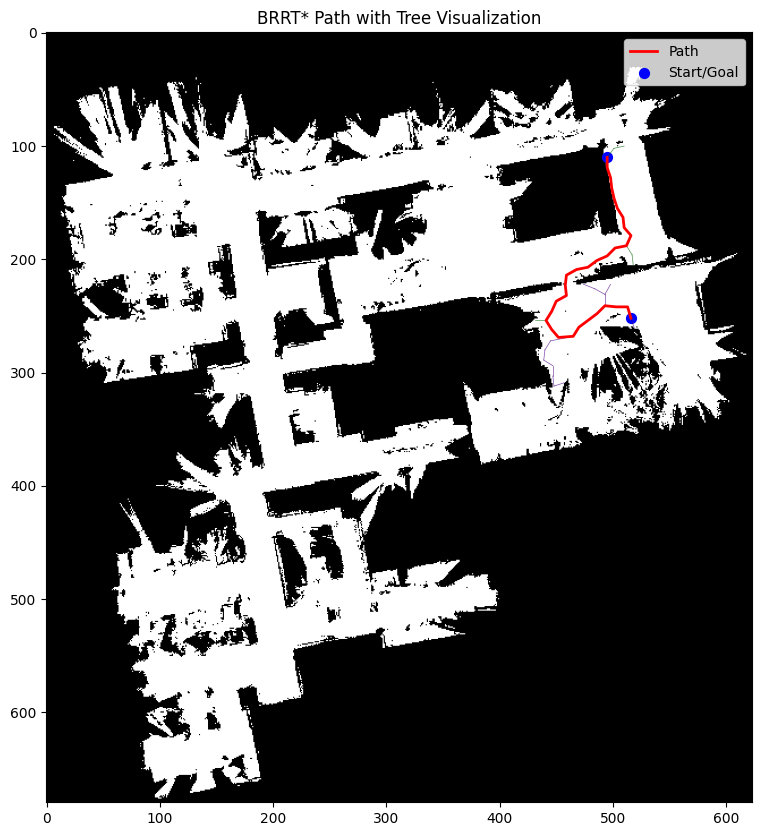

Path found in 28 iterations, Time: 0.01 seconds
Path Length: 98.21, Smoothness: 5.90


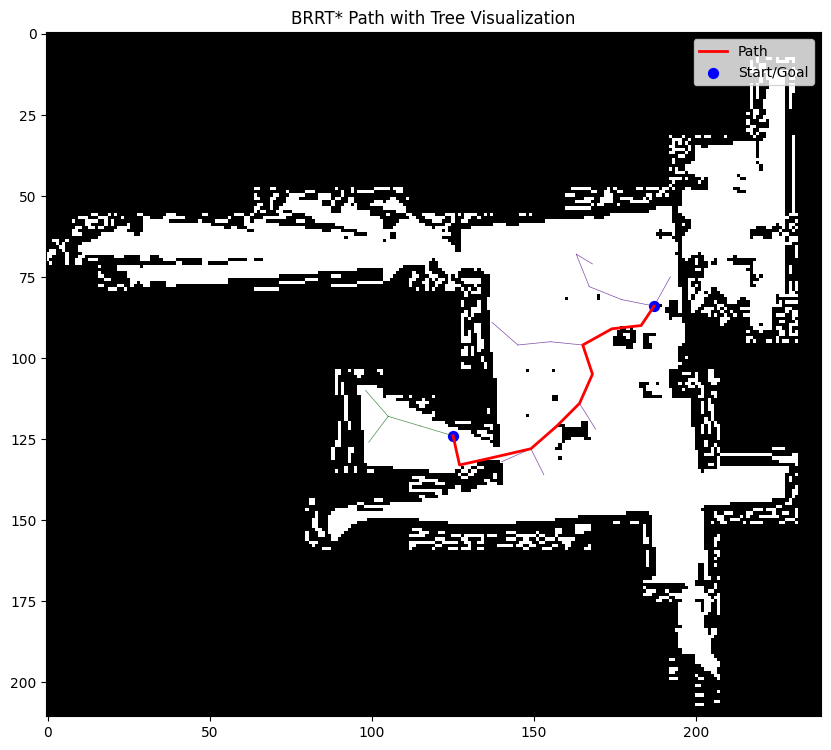

Path found in 10 iterations, Time: 0.01 seconds
Path Length: 123.39, Smoothness: 8.84


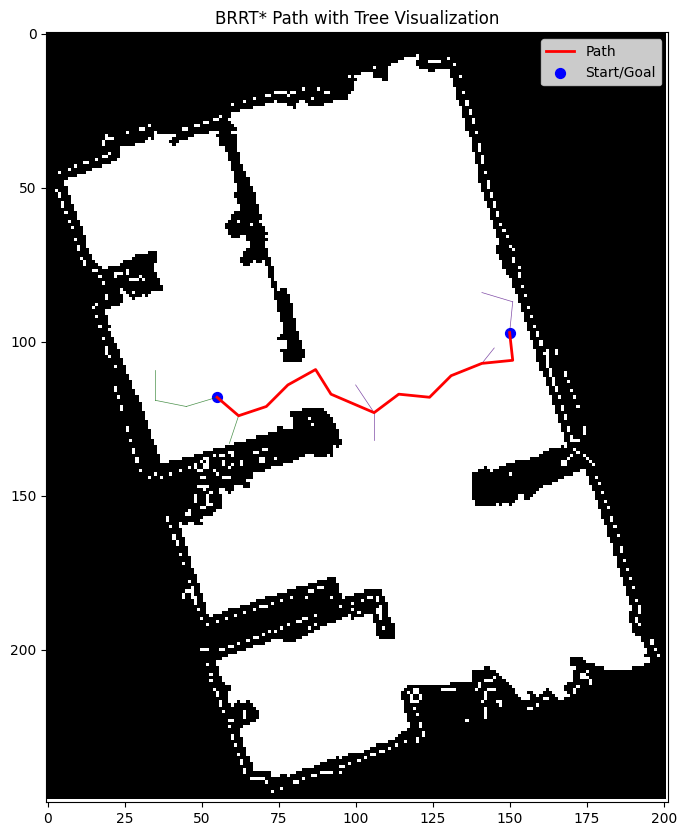

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from collections import deque
import imageio

class Node:
    def __init__(self, x, y, parent=None):
        self.x = x
        self.y = y
        self.parent = parent

def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def steer(from_node, to_point, step_size, image):
    vector = np.array(to_point) - np.array([from_node.x, from_node.y])
    distance = np.linalg.norm(vector)
    
    if distance == 0:
        return None

    direction = vector / distance
    new_point = np.array([from_node.x, from_node.y]) + direction * min(step_size, distance)
    new_point = new_point.astype(int)
    
    if is_collision_free(from_node, Node(new_point[0], new_point[1]), image):
        return Node(new_point[0], new_point[1], from_node)
    return None

def is_collision_free(node1, node2, image):
    x1, y1 = node1.x, node1.y
    x2, y2 = node2.x, node2.y
    line = np.linspace((x1, y1), (x2, y2), num=20, dtype=int)

    for x, y in line:
        if image[y, x] == 0:
            return False
    return True

def rewire(new_node, nodes, radius, image):
    for node in nodes:
        if node == new_node or node.parent is None:
            continue
        
        distance = euclidean_distance((new_node.x, new_node.y), (node.x, node.y))
        
        if distance < radius:
            new_cost = path_cost(new_node) + distance
            if new_cost < path_cost(node) and is_collision_free(new_node, node, image):
                node.parent = new_node

def path_cost(node):
    cost = 0
    current = node
    while current.parent:
        cost += euclidean_distance((current.x, current.y), (current.parent.x, current.parent.y))
        current = current.parent
    return cost

def extract_path(node_start, node_goal):
    path = deque()
    
    current = node_start
    while current:
        path.appendleft((current.x, current.y))
        current = current.parent
    
    current = node_goal.parent
    while current:
        path.append((current.x, current.y))
        current = current.parent
    
    return list(path)

def visualize_tree(image, nodes, color, linewidth=1):
    for node in nodes:
        if node.parent:
            cv2.line(image, (node.x, node.y), (node.parent.x, node.parent.y), color, linewidth)

def calculate_path_length(path):
    return sum(euclidean_distance(path[i], path[i + 1]) for i in range(len(path) - 1))

def calculate_smoothness(path):
    angles = []
    for i in range(1, len(path) - 1):
        vector1 = np.array(path[i]) - np.array(path[i - 1])
        vector2 = np.array(path[i + 1]) - np.array(path[i])
        angle = np.arccos(
            np.clip(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)), -1.0, 1.0)
        )
        angles.append(angle)
    smoothness = sum(angles)
    return smoothness

def brrt_star(image, start_coords, goal_coords, max_iterations=1000, step_size=10, goal_radius=10, rewire_radius=20):
    height, width = image.shape
    start = Node(*start_coords)
    goal = Node(*goal_coords)
    nodes_start = [start]
    nodes_goal = [goal]

    images_for_gif = []
    found_path = False
    start_time = time.time()

    for iteration in range(max_iterations):
        rand_point = (np.random.randint(0, width), np.random.randint(0, height))

        nearest_start = min(nodes_start, key=lambda node: euclidean_distance((node.x, node.y), rand_point))
        new_start = steer(nearest_start, rand_point, step_size, image)
        if new_start:
            nodes_start.append(new_start)
            rewire(new_start, nodes_start, rewire_radius, image)

        nearest_goal = min(nodes_goal, key=lambda node: euclidean_distance((node.x, node.y), rand_point))
        new_goal = steer(nearest_goal, rand_point, step_size, image)
        if new_goal:
            nodes_goal.append(new_goal)
            rewire(new_goal, nodes_goal, rewire_radius, image)

        vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
        visualize_tree(vis_image, nodes_start, (255, 0, 0))
        visualize_tree(vis_image, nodes_goal, (0, 0, 255))
        images_for_gif.append(vis_image)

        for node_start in nodes_start:
            for node_goal in nodes_goal:
                if euclidean_distance((node_start.x, node_start.y), (node_goal.x, node_goal.y)) < goal_radius:
                    found_path = True
                    path = extract_path(node_start, node_goal)
                    end_time = time.time()
                    time_taken = end_time - start_time
                    return path, iteration, time_taken, images_for_gif, nodes_start, nodes_goal

    return None, max_iterations, time.time() - start_time, images_for_gif, nodes_start, nodes_goal

def process_image(image_path, start_coords, goal_coords, output_gif):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ret, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    path, iterations, time_taken, images_for_gif, nodes_start, nodes_goal = brrt_star(binary_image, start_coords, goal_coords)

    if path:
        path_length = calculate_path_length(path)
        smoothness = calculate_smoothness(path)

        print(f"Path found in {iterations} iterations, Time: {time_taken:.2f} seconds")
        print(f"Path Length: {path_length:.2f}, Smoothness: {smoothness:.2f}")

        plt.figure(figsize=(10, 10))
        vis_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
        
        # Plot start tree in dark green
        for node in nodes_start:
            if node.parent:
                plt.plot([node.x, node.parent.x], [node.y, node.parent.y], color='darkgreen', linewidth=0.5, alpha=0.7)
        
        # Plot goal tree in dark purple
        for node in nodes_goal:
            if node.parent:
                plt.plot([node.x, node.parent.x], [node.y, node.parent.y], color='indigo', linewidth=0.5, alpha=0.7)
        
        # Plot the final path
        path_x, path_y = zip(*path)
        plt.imshow(vis_image)
        plt.plot(path_x, path_y, color='red', linewidth=2, label='Path')
        plt.scatter(*zip(*[start_coords, goal_coords]), color='blue', s=50, label='Start/Goal')
        plt.legend()
        plt.title('BRRT* Path with Tree Visualization')
        plt.show()

        # Save the GIF
        imageio.mimsave(output_gif, images_for_gif, duration=0.05)
    else:
        print("Path not found.")


# Inputs with image paths and start/goal coordinates
inputs = [
    {"image_path": "/home/rgautham20/MR/final_project/data1.png", "start": (495, 110), "goal": (516, 252), "output_gif": "/home/rgautham20/MR/final_project/rrt_star_expansion_1.gif"},
    {"image_path": "/home/rgautham20/MR/final_project/b_data2.png", "start": (125, 124), "goal": (187, 84), "output_gif": "/home/rgautham20/MR/final_project/rrt_star_expansion_2.gif"},
    {"image_path": "/home/rgautham20/MR/final_project/b_data3.png", "start": (55, 118), "goal": (150, 97), "output_gif": "/home/rgautham20/MR/final_project/rrt_star_expansion_3.gif"}
]

for input_data in inputs:
    process_image(input_data["image_path"], input_data["start"], input_data["goal"], input_data["output_gif"])
